In [1]:
from collections import defaultdict
import sys

import cv2
import pandas as pd
import numpy as np
import tifffile as tiff
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import matplotlib.pyplot
df=pd.read_csv('train_v4.csv',header=0)

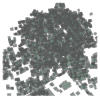

In [2]:
bldg=df[df['ClassType']==1]
bldg=bldg[bldg['MultipolygonWKT']!='MULTIPOLYGON EMPTY']
wkt=bldg[bldg.ImageId=='6120_2_2'].iloc[0,2]
sMultiPolygon = shapely.wkt.loads(wkt)
sMultiPolygon

In [3]:
grid_sizes=pd.read_csv('grid_sizes.csv',header=0)
im1=grid_sizes[grid_sizes['Unnamed: 0']=='6120_2_2']
x_max=float(im1.Xmax)
y_min=float(im1.Ymin)

imName = 'three_band/6120_2_2.tif'
im_rgb=tiff.imread(imName).transpose([1,2,0])

im_size = im_rgb.shape[:2]

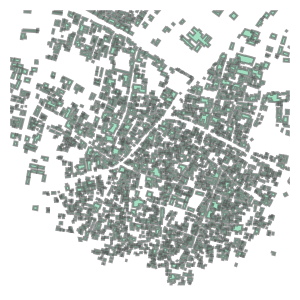

In [32]:
def get_scalars():
    h,w =im_size
    w_=w*(w/(w+1))/x_max
    h_=h*(h/(h+1))/y_min
    return w_,h_

xscaler, yscaler = get_scalars()

poly_scaled=shapely.affinity.scale(sMultiPolygon,xfact=xscaler,yfact=yscaler,origin=(0,0,0))
poly_scaled

In [5]:
def mask_for_polygons(polygons):
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

train_mask=mask_for_polygons(poly_scaled)
train_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

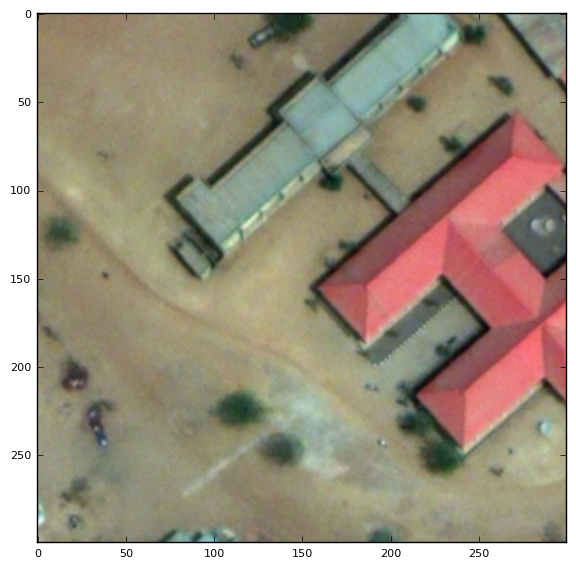

In [17]:
def scale_percentile(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 0, axis=0)
    maxs = np.percentile(matrix, 100, axis=0) - mins
    matrix = (matrix - mins[None, :]) / (maxs[None, :])
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix

tiff.imshow(255 * scale_percentile(im_rgb[2900:3200,2000:2300]))
matplotlib.pyplot.show()

In [18]:
def show_mask(m):
    # hack for nice display
    tiff.imshow(255 * np.stack([m, m, m]));
show_mask(train_mask[2900:3200,2000:2300])

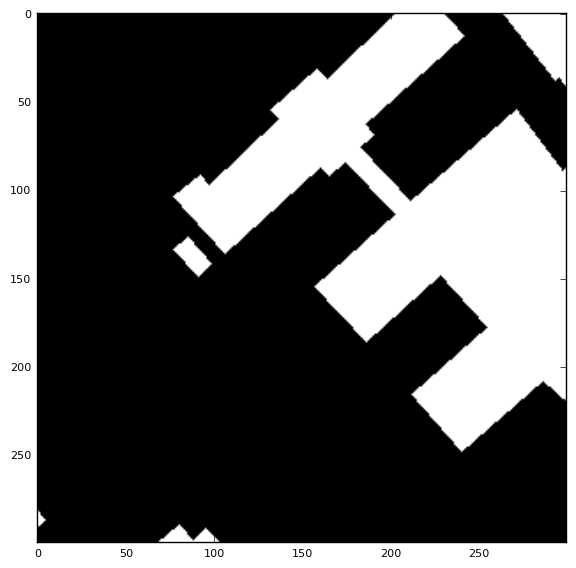

In [19]:
matplotlib.pyplot.show()

In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import average_precision_score

In [25]:
xs = im_rgb.reshape(-1, 3).astype(np.float32)
ys = train_mask.reshape(-1)
pipeline = make_pipeline(StandardScaler(), SGDClassifier(loss='log'))

print('training...')
# do not care about overfitting here
pipeline.fit(xs, ys)
pred_ys = pipeline.predict_proba(xs)[:, 1]
print('average precision', average_precision_score(ys, pred_ys))
pred_mask = pred_ys.reshape(train_mask.shape)

training...
average precision 0.832398245372


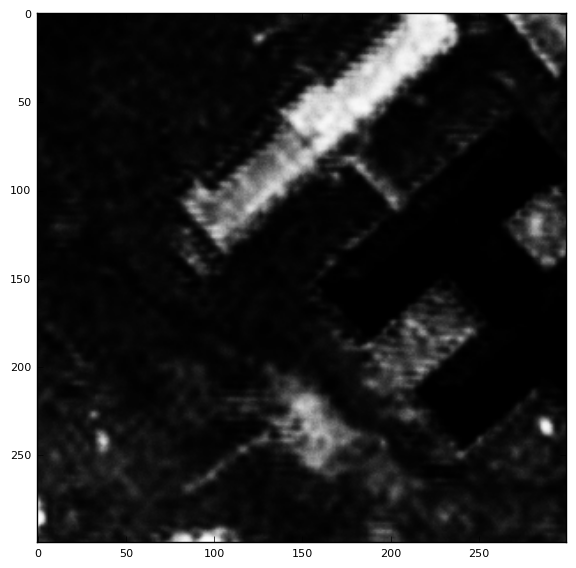

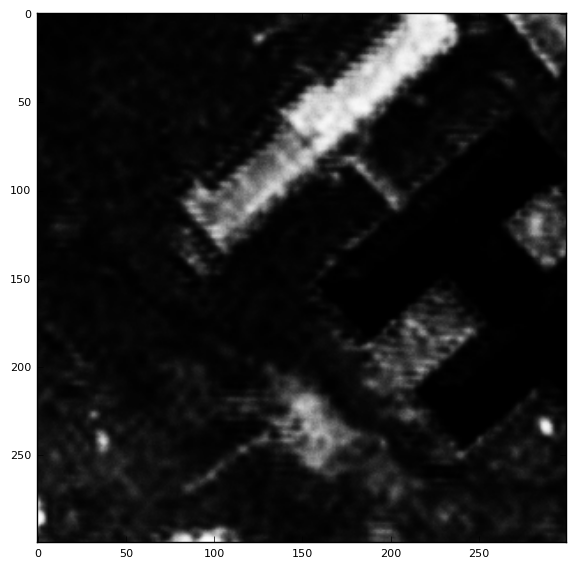

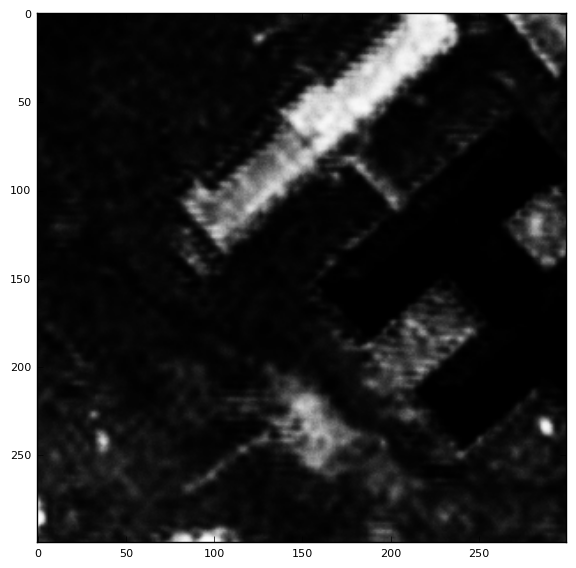

In [27]:
show_mask(pred_mask[2900:3200,2000:2300])
matplotlib.pyplot.show()
show_mask(a)
matplotlib.pyplot.show()


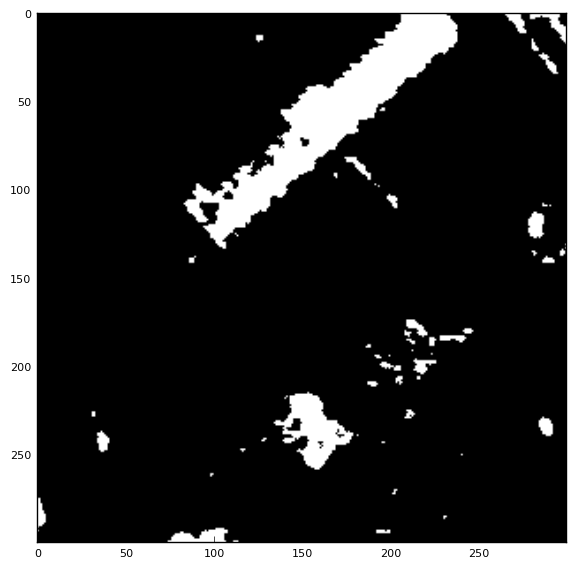

In [12]:
threshold = 0.335
pred_binary_mask = pred_mask >= threshold
show_mask(pred_binary_mask[2900:3200,2000:2300])
matplotlib.pyplot.show()

In [13]:
# check jaccard on the pixel level
tp, fp, fn = (( pred_binary_mask &  train_mask).sum(),
              ( pred_binary_mask & ~train_mask).sum(),
              (~pred_binary_mask &  train_mask).sum())
print('Pixel jaccard', tp / (tp + fp + fn))

Pixel jaccard 0.606046957711


3019568